<a href="https://colab.research.google.com/github/beamscource/colab_notebooks/blob/main/pytorch_speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch-Kaldi

- https://github.com/mravanelli/pytorch-kaldi
- https://arxiv.org/abs/1811.07453

**Introduction**

Kaldi (https://github.com/kaldi-asr/kaldi) is nowadays an established framework used to develop
state-of-the-art speech recognizers.

It relies on finite-state transducers (FSTs) and provides a set of C++ libraries for efficiently implementing state-of-the-art speech recognition systems. Moreover, the toolkit includes a large set of recipes that
cover all the most popular speech corpora.

PyTorch is a Python package that implements efficient GPU-based tensor computations and facilitates the design of
neural architectures, thanks to proper routines for automatic gradient computation.

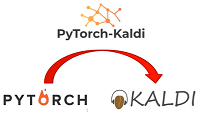

The PyTorch-Kaldi project aims to bridge the gap between these
popular toolkits, trying to o inherit the efficiency of Kaldi and the
flexibility of PyTorch.

The toolkit implements acoustic models in PyTorch,
while feature extraction, label/alignment computation, and decoding are performed with Kaldi, making it suitable to develop stateof-the-art DNN-HMM speech recognizers.

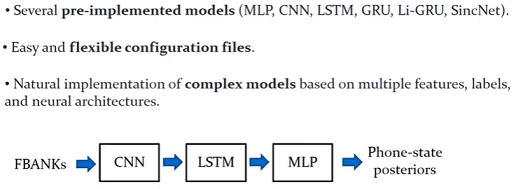

Combinations between deep learning models, acoustic features, and labels are also supported, enabling the use of complex neural architectures. For instance, users can employ a cascade between CNNs, LSTMs, and DNNs, or run in parallel several models that share some hidden layers.

Users can also explore different acoustic features, context duration, neuron activations (e.g., ReLU, leaky ReLU), normalizations (e.g., batch and layer normalization), cost functions, regularization strategies (e.g, L2, dropout), optimization algorithms (e.g., Adam, RMSPROP), and many other hyper-parameters of an ASR system through simple edits of configuration files.

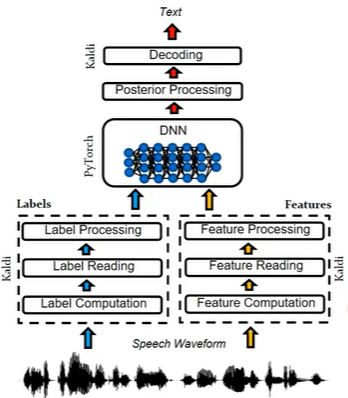

The main script `run_exp.py` is written in python
and manages all the phases involved in an ASR system, including
feature and label extraction, training, validation, decoding, and scoring. 

The toolkit can perform computations on both local machines and HPC cluster, and supports multi-gpu training, recovery
strategy, and automatic data chunking.

**Configuration file**

The main script takes as input a configuration file in INI format. See a description here https://github.com/mravanelli/pytorch-kaldi#description-of-the-configuration-files

In [ ]:
[exp]
cmd = 
run_nn_script = run_nn
out_folder = exp/TIMIT_MLP_basic5
seed = 1234
use_cuda = True
multi_gpu = False
save_gpumem = False
n_epochs_tr = 24

[dataset1]
data_name = TIMIT_tr
fea = fea_name=mfcc
    fea_lst=quick_test/data/train/feats_mfcc.scp
    fea_opts=apply-cmvn --utt2spk=ark:quick_test/data/train/utt2spk  ark:quick_test/mfcc/train_cmvn_speaker.ark ark:- ark:- | add-deltas --delta-order=2 ark:- ark:- |
    cw_left=5
    cw_right=5
    
lab = lab_name=lab_cd
    lab_folder=quick_test/dnn4_pretrain-dbn_dnn_ali
    lab_opts=ali-to-pdf
    lab_count_file=auto
    lab_data_folder=quick_test/data/train/
    lab_graph=quick_test/graph
    
n_chunks = 5

[dataset2]
data_name = TIMIT_dev
fea = fea_name=mfcc
    fea_lst=quick_test/data/dev/feats_mfcc.scp
    fea_opts=apply-cmvn --utt2spk=ark:quick_test/data/dev/utt2spk  ark:quick_test/mfcc/dev_cmvn_speaker.ark ark:- ark:- | add-deltas --delta-order=2 ark:- ark:- |
    cw_left=5
    cw_right=5
    
lab = lab_name=lab_cd
    lab_folder=quick_test/dnn4_pretrain-dbn_dnn_ali_dev
    lab_opts=ali-to-pdf
    lab_count_file=auto
    lab_data_folder=quick_test/data/dev/
    lab_graph=quick_test/graph
n_chunks = 1

[dataset3]
data_name = TIMIT_test
fea = fea_name=mfcc
    fea_lst=quick_test/data/test/feats_mfcc.scp
    fea_opts=apply-cmvn --utt2spk=ark:quick_test/data/test/utt2spk  ark:quick_test/mfcc/test_cmvn_speaker.ark ark:- ark:- | add-deltas --delta-order=2 ark:- ark:- |
    cw_left=5
    cw_right=5
    
lab = lab_name=lab_cd
    lab_folder=quick_test/dnn4_pretrain-dbn_dnn_ali_test
    lab_opts=ali-to-pdf
    lab_count_file=auto
    lab_data_folder=quick_test/data/test/
    lab_graph=quick_test/graph
    
n_chunks = 1

[data_use]
train_with = TIMIT_tr
valid_with = TIMIT_dev
forward_with = TIMIT_test

[batches]
batch_size_train = 128
max_seq_length_train = 1000
increase_seq_length_train = False
start_seq_len_train = 100
multply_factor_seq_len_train = 2
batch_size_valid = 128
max_seq_length_valid = 1000

[architecture1]
arch_name = MLP_layers1
arch_proto = proto/MLP.proto
arch_library = neural_networks
arch_class = MLP
arch_pretrain_file = none
arch_freeze = False
arch_seq_model = False
dnn_lay = 1024,1024,1024,1024,N_out_lab_cd
dnn_drop = 0.15,0.15,0.15,0.15,0.0
dnn_use_laynorm_inp = False
dnn_use_batchnorm_inp = False
dnn_use_batchnorm = True,True,True,True,False
dnn_use_laynorm = False,False,False,False,False
dnn_act = relu,relu,relu,relu,softmax
arch_lr = 0.08
arch_halving_factor = 0.5
arch_improvement_threshold = 0.001
arch_opt = sgd
opt_momentum = 0.0
opt_weight_decay = 0.0
opt_dampening = 0.0
opt_nesterov = False

[proto]
library=path
class=MLP
dnn_lay=str_list
dnn_drop=float_list(0.0,1.0)
dnn_use_laynorm_inp=bool
dnn_use_batchnorm_inp=bool
dnn_use_batchnorm=bool_list
dnn_use_laynorm=bool_list
dnn_act=str_list

[model]
model_proto = proto/model.proto
model = out_dnn1=compute(MLP_layers1,mfcc)
    loss_final=cost_nll(out_dnn1,lab_cd)
    err_final=cost_err(out_dnn1,lab_cd)

[model]
model_proto=proto/model.proto
model:conc1=concatenate(mfcc,fbank)
      conc2=concatenate(conc1,fmllr)
      out_dnn1=compute(MLP_layers_first,conc2)
      out_dnn2=compute(liGRU_layers,out_dnn1)
      out_dnn3=compute(MLP_layers_second,out_dnn2)
      out_dnn4=compute(MLP_layers_last,out_dnn3)
      out_dnn5=compute(MLP_layers_last2,out_dnn3)
      loss_mono=cost_nll(out_dnn5,lab_mono)
      loss_mono_w=mult_constant(loss_mono,1.0)
      loss_cd=cost_nll(out_dnn4,lab_cd)
      loss_final=sum(loss_cd,loss_mono_w)     
      err_final=cost_err(out_dnn4,lab_cd)

[forward]
forward_out = out_dnn1
normalize_posteriors = True
normalize_with_counts_from = lab_cd
save_out_file = True
require_decoding = True

[decoding]
decoding_script_folder = kaldi_decoding_scripts/
decoding_script = decode_dnn.sh
decoding_proto = proto/decoding.proto
min_active = 200
max_active = 7000
max_mem = 50000000
beam = 13.0
latbeam = 8.0
acwt = 0.2
max_arcs = -1
skip_scoring = false
scoring_script = local/score.sh
scoring_opts = "--min-lmwt 1 --max-lmwt 10"
norm_vars = False



In [ ]:
python run_exp.py quick_test/example_newcode.cfg --optimization,lr=0.01 --batches,batch_size=4

**Features**

The feature extraction is performed with Kaldi, that natively provides c++ libraries (e.g., *compute-mfcc-feats*, *compute-fbank-feats*,
*compute-plp-feats*) to efficiently extract the most popular speech recognition features.

PyTorch-Kaldi can manage multiple feature streams.
For instance, users can define models that exploit combinations of
MFCCs, FBANKs, PLP, and fMLLR coefficients

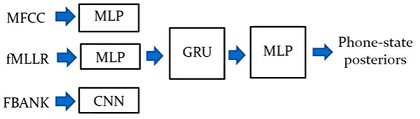

**Labels**

The main labels used for training the acoustic model derive from a
forced alignment procedure between the speech features and the sequence of context-dependent phone states computed by Kaldi with
a phonetic decision tree.

**Chunks and multi-batch composition**

PyTorch-Kaldi automatically splits the full dataset into a number
of chunks, which are composed of labels and features randomly
sampled from the full corpus. Each chunk is then stored into the
GPU or CPU memory and processed by the neural training algorithm
run nn.py. The toolkit dynamically composes different chunks at
each epoch. A set of mini-batches are then derived from them.

The way mini-batches are gathered strongly depends on the typology of the neural network. For feed-forward models, the minibatches are composed of randomly shuffled features and labels sampled from the chunk. For recurrent networks, the minibatches must
be composed of full sentences. Different sentences, however, are
likely to have different duration, making zero-padding necessary to
form mini-batches of the same size. PyTorch-Kaldi sorts the speech
sequences in ascending order according to their lengths (i.e., short
sentences are processed first).

**NN processing**

Each minibatch is processed by a neural network implemented with
PyTorch, that takes as input the features and as outputs a set of posterior probabilities over the context-dependent phone states. The code is designed to easily plug-in customized models. The new model can be simply defined by adding a new `nn-Module` class into the neural `nets.py`.

**Decoding and scoring**

The acoustic posterior probabilities generated by the neural network
are normalized by their prior before feeding the HMM-based decoder of Kaldi. The decoder merges the acoustic scores with the language probabilities derived by an n-gram language model and tries
to retrieve the sequence of words uttered in the speech signal using a
beam-search algorithm. The final Word-Error-Rate (WER) score is
computed with the NIST SCTK scoring toolkit.

# Speechbrain

- https://speechbrain.github.io/
- https://arxiv.org/pdf/2106.04624.pdf - SpeechBrain + survey of other tools

- https://speechbrain.readthedocs.io/en/latest/tutorials.html

- https://huggingface.co/speechbrain/tts-tacotron2-ljspeech

# ESPNet

- https://github.com/espnet/espnet
- https://colab.research.google.com/github/espnet/notebook/blob/master/espnet2_tts_realtime_demo.ipynb#scrollTo=vrRM57hhgtHy

# Fairseq (Meta AI)

- https://github.com/facebookresearch/fairseq

# NeMo (NVIDIA)

- https://github.com/NVIDIA/NeMo

https://github.com/rhoposit?tab=repositories